In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Physical constants

# Faraday constant, in coulombs per mole
F = 96485
# Molar gas constant, in Joules per mole Kelvin
R = 8.314
# Vacuum permittivity, in Farads per meter
epsilon_0 = 8.8541878128 * (10 ** -12)

In [39]:
# from https://python.algorithms-library.com/maths/runge_kutta
def runge_kutta(f, y0, x0, h, x_end):
    """
    Calculate the numeric solution at each step to the ODE f(x, y) using RK4

    https://en.wikipedia.org/wiki/Runge-Kutta_methods

    Arguments:
    f -- The ode as a function of x and y
    y0 -- the initial value for y
    x0 -- the initial value for x
    h -- the stepsize
    x_end -- the end value for x

    >>> # the exact solution is math.exp(x)
    >>> def f(x, y):
    ...     return y
    >>> y0 = 1
    >>> y = runge_kutta(f, y0, 0.0, 0.01, 5)
    >>> y[-1]
    148.41315904125113
    """
    N = int(np.ceil((x_end - x0) / h))
    y = np.zeros((N + 1,len(y0)))
    x_arr = np.zeros((N + 1,))
    y[0] = y0
    x_arr[0] = x0
    x = x0

    for k in range(N):
#         print("k1")
        k1 = f(x, *y[k])
#         print("k2")
        k2 = f(x + 0.5 * h, *(y[k] + 0.5 * h * k1))
#         print("k3")
        k3 = f(x + 0.5 * h, *(y[k] + 0.5 * h * k2))
#         print("k4")
        k4 = f(x + h, *(y[k] + h * k3))
        y[k + 1] = y[k] + (1 / 6) * h * (k1 + 2 * k2 + 2 * k3 + k4)
        x_arr[k + 1] = x
        x += h

    return x_arr, y

In [72]:
# units are millimolar = mole/m^3
extracellular_k_level = 5
intracellular_k_level = 105

extracellular_na_level = 150
intracellular_na_level = 10

CHARGE_EN = 1
# units are meters
# 4nm
membrane_thickness = 4 * (10 ** -9)
# 10 um
cell_radius = 40 * (10 ** -6)

cell_SA = 4 * math.pi * cell_radius ** 2
cell_volume = 4 /3 * math.pi * cell_radius ** 3

In [4]:
# input: coulombs
# output: volts
def membrane_potential(cell_charge):
    return cell_charge / (4 * math.pi * epsilon_0 * cell_radius) * membrane_thickness

In [108]:
# Ionic permeability, in m^2 / second
K_CROSS_PROB = 10 ** -13
NA_CROSS_PROB = K_CROSS_PROB * 0.05 #https://en.wikipedia.org/wiki/Resting_potential#Generation_of_the_resting_potential

In [109]:
def goldman_flux(in_conc, out_conc, membrane_voltage, n_a=1, p_a=1, temp=310):
    if membrane_voltage == 0 or n_a == 0:
        return p_a * (in_conc - out_conc)
    mu = F * membrane_voltage / (R * temp)
    return mu * n_a * p_a * (out_conc - in_conc * math.exp(n_a * mu)) / (1 - math.exp(n_a * mu))

# Return derivatives of intracellular K conc, intracellular Na conc, and cell charge
def goldman_derivatives(t, in_k_conc, in_na_conc, cell_charge):
    # volts
    membrane_voltage = membrane_potential(cell_charge)
    # moles per second per square meter
    k_flux_out = goldman_flux(in_k_conc, extracellular_k_level, membrane_voltage, p_a=K_CROSS_PROB/membrane_thickness, n_a=CHARGE_EN)
    na_flux_out = goldman_flux(in_na_conc, extracellular_na_level, membrane_voltage, p_a=NA_CROSS_PROB/membrane_thickness, n_a=CHARGE_EN)
    in_k_conc_der = -k_flux_out * cell_SA / cell_volume
    in_na_conc_der = -na_flux_out * cell_SA / cell_volume
    cell_charge_der = -F * cell_SA * (k_flux_out + na_flux_out)
#     print("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}".format(in_k_conc, in_na_conc, cell_charge, k_flux_out, na_flux_out, in_k_conc_der, in_na_conc_der, cell_charge_der))
    return np.array([in_k_conc_der, in_na_conc_der, cell_charge_der])

In [118]:
CHARGE_EN = 1
y0 = [intracellular_k_level, intracellular_na_level, 0]
x, y = runge_kutta(goldman_derivatives, y0, 0, 10 ** -3, 10)

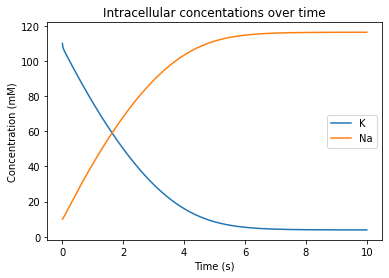

In [119]:
plt.title("Intracellular concentations over time") 
plt.xlabel("Time (s)") 
plt.ylabel("Concentration (mM)")
plt.plot(x, y[:,0])
plt.plot(x, y[:,1])
# plt.ylim(0, 150)
plt.legend(["K", "Na"])

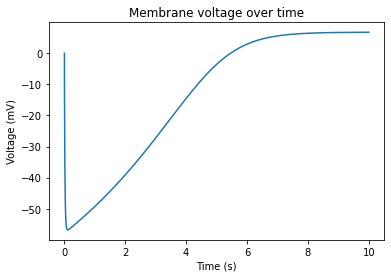

In [120]:
plt.title("Membrane voltage over time") 
plt.xlabel("Time (s)") 
plt.ylabel("Voltage (mV)")
plt.plot(x, membrane_potential(y[:,2]) * 1000)

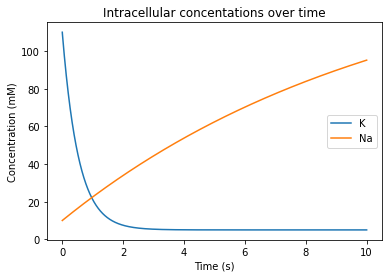

In [121]:
CHARGE_EN = 0
y0 = [intracellular_k_level, intracellular_na_level, 0]
x, y = runge_kutta(goldman_derivatives, y0, 0, 10 ** -3, 10)
plt.title("Intracellular concentations over time") 
plt.xlabel("Time (s)") 
plt.ylabel("Concentration (mM)")
plt.plot(x, y[:,0])
plt.plot(x, y[:,1])
# plt.ylim(0, 150)
plt.legend(["K", "Na"])

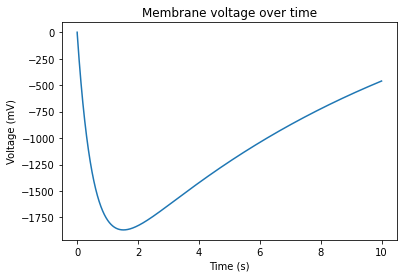

In [122]:
plt.title("Membrane voltage over time") 
plt.xlabel("Time (s)") 
plt.ylabel("Voltage (mV)")
plt.plot(x, membrane_potential(y[:,2]) * 1000)

In [35]:
goldman_derivatives(0, 20, 5, 0)

array([-1.12500000e+00,  0.00000000e+00,  4.54674851e-10])

In [37]:
goldman_derivatives(0, 20, 5, 10 ** -8)

array([-2.55160394e+00,  0.00000000e+00,  1.03124457e-09])

case of higher concentration outside than in, so ions flow in
da/dz positive
jA negative
jA is flux out